# Assignment: SVD Preprocessing on MNIST with Logistic Regression

## Instructions:
In this assignment, you will apply **Singular Value Decomposition (SVD)** as a preprocessing step to the **MNIST dataset** and train a **logistic regression classifier**. You will compare the model performance and training time when using different levels of SVD for dimensionality reduction.

In this assignment, you will need to:
1. Load the MNIST dataset and normalize it.
2. Perform SVD and reduce the dimensions of the data.
3. Train a logistic regression model on the original and SVD-reduced data.
4. Measure and compare the training time and accuracy of the model with varying SVD components.
5. Plot the results and analyze how SVD impacts the performance and efficiency of the model.

***
Your tasks include:
1. Implement SVD algorithm. You are not allowed to directly use SVD implemented by other packages, but you may use functions in NumPy. (Part 2)
2. Explore the accuracy and time performance from different numbers of SVD components. (Part 4)
3. Visualize the accuracy, time performance and top 5 singular vectors in the dataset, analyze and explain which number of SVD component looks best to you? (Part 4,5&6) Hint: singular vectors should be reshaped to 28x28 images for visualization.
***
**Note that you may not import any other function or package.** Let's get started!


## Part 1: Load the MNIST dataset and preprocess the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report

import ssl
import urllib
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

# Normalize the data
X = X / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading MNIST dataset...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Part 2: Implement SVD for Dimensionality Reduction

In [3]:
def apply_svd_custom(X_train, X_test, n_components):
    """
    Perform SVD on X_train, reduce the number of components, and apply the same transformation to X_test.
    
    Args:
    - X_train (ndarray): The training data matrix.
    - X_test (ndarray): The test data matrix.
    - n_components (int): The number of components to retain.
    
    Returns:
    - V_T_train (ndarray): The right singular vectors (transposed).
    - X_train_svd (ndarray): The reduced-dimensional training data.
    - X_test_svd (ndarray): The reduced-dimensional test data.
    """
    # Step 1: Center the training data (subtract mean of each feature)
    X_train_centered = X_train - np.mean(X_train, axis=0)
    
    # Step 2: Compute covariance matrix (X^T X)
    covariance_matrix = np.dot(X_train_centered.T, X_train_centered)
    
    # Step 3: Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Step 4: Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Step 5: Ensure that eigenvalues and eigenvectors are real
    sorted_eigenvalues = np.real(sorted_eigenvalues)
    sorted_eigenvectors = np.real(sorted_eigenvectors)
    
    # Step 6: Keep only the top 'n_components' eigenvectors (for dimensionality reduction)
    top_eigenvectors = sorted_eigenvectors[:, :n_components]
    
    # Step 7: Project the training data onto the new subspace
    X_train_svd = np.dot(X_train_centered, top_eigenvectors)
    
    # Ensure that X_train_svd has the same number of rows as X_train (56,000 samples)
    assert X_train_svd.shape[0] == X_train.shape[0], f"Mismatch in X_train_svd shape: {X_train_svd.shape[0]} != {X_train.shape[0]}"
    
    # Step 8: Center the test data using the mean of the training data
    X_test_centered = X_test - np.mean(X_train, axis=0)
    
    # Step 9: Project the test data onto the same subspace as the training data
    X_test_svd = np.dot(X_test_centered, top_eigenvectors)
    
    # Ensure that X_test_svd has the same number of rows as X_test (14,000 samples)
    assert X_test_svd.shape[0] == X_test.shape[0], f"Mismatch in X_test_svd shape: {X_test_svd.shape[0]} != {X_test.shape[0]}"
    
    return top_eigenvectors.T, X_train_svd, X_test_svd

## Part 3: Train Logistic Regression and Measure Performance

In [5]:
# Function to train logistic regression and track training time
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='saga', random_state=42, multi_class='multinomial')
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time


In [6]:
# Check shape of X_train and X_test before applying SVD
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56000, 784)
X_test shape: (14000, 784)
y_train shape: (56000,)
y_test shape: (14000,)


## Part 4: Experiment with Different Levels of SVD

Now, apply SVD with varying numbers of components and observe how the dimensionality reduction impacts the model's performance. Record both the accuracy and training time for each number of components.


In [7]:
# Define a range of SVD components to test
svd_components = [20, 60, 100, 140, 180, 220, 260, 300]  # Example components list

# Store the results
results = []

print("Training models with different levels of SVD preprocessing...")
for n_components in svd_components:
     print(f"Applying custom SVD with {n_components} components...")

     # Apply custom SVD to the training and test sets
     V_T_train, X_train_svd, X_test_svd = apply_svd_custom(X_train, X_test, n_components)

     # Ensure that X_train_svd has the same number of rows as X_train (56,000 samples)
     assert X_train_svd.shape[0] == X_train.shape[0], f"Mismatch in X_train_svd shape: {X_train_svd.shape[0]} != {X_train.shape[0]}"

     # Ensure that X_test_svd has the same number of rows as X_test (14,000 samples)
     assert X_test_svd.shape[0] == X_test.shape[0], f"Mismatch in X_test_svd shape: {X_test_svd.shape[0]} != {X_test.shape[0]}"

     # Train the logistic regression model and get accuracy and training time
     accuracy, training_time = train_logistic_regression(X_train_svd, y_train, X_test_svd, y_test)

     # Record the results
     print(f"SVD components: {n_components}, Accuracy: {accuracy:.4f}, Training time: {training_time:.4f} seconds")
     results.append((n_components, accuracy, training_time))

Training models with different levels of SVD preprocessing...
Applying custom SVD with 20 components...
SVD components: 20, Accuracy: 0.8784, Training time: 1.0945 seconds
Applying custom SVD with 60 components...
SVD components: 60, Accuracy: 0.9131, Training time: 6.9448 seconds
Applying custom SVD with 100 components...
SVD components: 100, Accuracy: 0.9181, Training time: 18.3182 seconds
Applying custom SVD with 140 components...
SVD components: 140, Accuracy: 0.9201, Training time: 28.8125 seconds
Applying custom SVD with 180 components...
SVD components: 180, Accuracy: 0.9216, Training time: 38.4331 seconds
Applying custom SVD with 220 components...
SVD components: 220, Accuracy: 0.9209, Training time: 50.0923 seconds
Applying custom SVD with 260 components...
SVD components: 260, Accuracy: 0.9214, Training time: 63.7528 seconds
Applying custom SVD with 300 components...
SVD components: 300, Accuracy: 0.9206, Training time: 75.3868 seconds


## Part 5: Visualize and Analyze the Results

Finally, plot the accuracy, training time as a function of the number of SVD components, and top 5 singular vectors. This will help you understand the trade-off between dimensionality reduction, accuracy, and model training time, and how SVD generally works. Hint: singular vectors should be reshaped to 28x28 images for visualization.


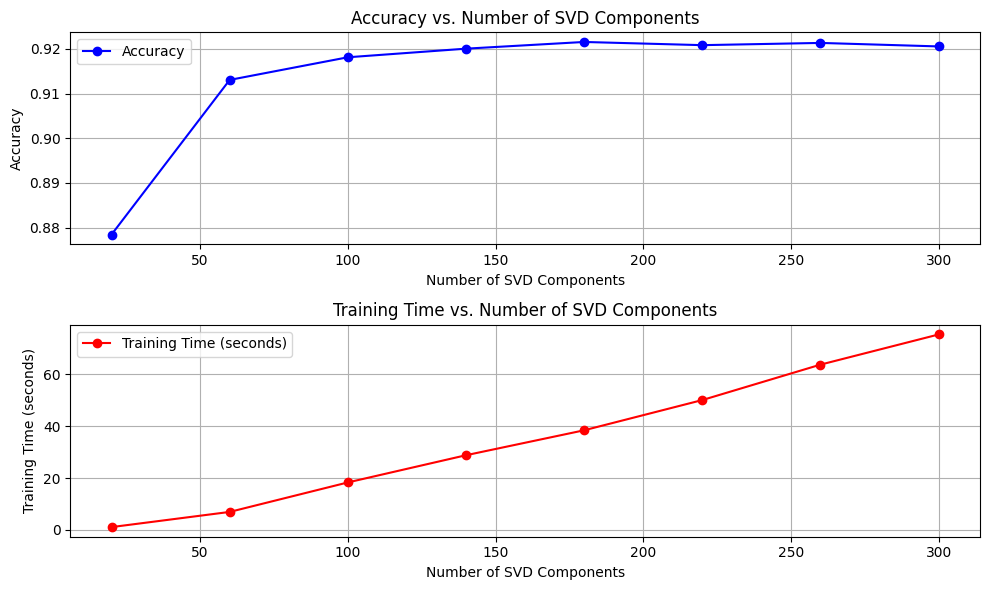

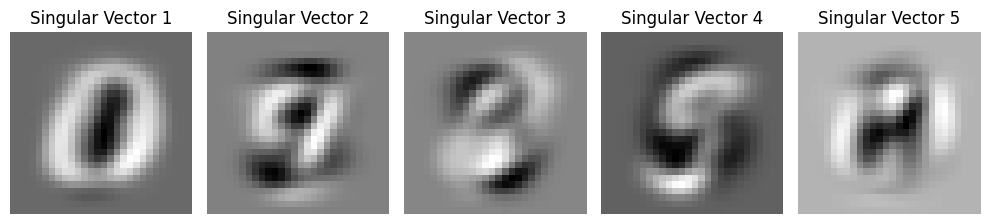

In [8]:
# Part 5: Visualize and Analyze the Results

# Extract n_components, accuracy, and training time from the results
n_components_list = [result[0] for result in results]
accuracy_list = [result[1] for result in results]
training_time_list = [result[2] for result in results]

# Plot Accuracy and Training Time as a function of the number of SVD components
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.subplot(2, 1, 1)
plt.plot(n_components_list, accuracy_list, marker='o', color='b', label='Accuracy')
plt.xlabel('Number of SVD Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of SVD Components')
plt.grid(True)
plt.legend()

# Plot training time
plt.subplot(2, 1, 2)
plt.plot(n_components_list, training_time_list, marker='o', color='r', label='Training Time (seconds)')
plt.xlabel('Number of SVD Components')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Number of SVD Components')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Visualize the top 5 singular vectors reshaped to 28x28 images
# V_T_train contains the right singular vectors, take the top 5 rows of V_T_train
top_5_singular_vectors = V_T_train[:5]  # Take the top 5 singular vectors

plt.figure(figsize=(10, 4))

for i, singular_vector in enumerate(top_5_singular_vectors):
    plt.subplot(1, 5, i + 1)
    plt.imshow(singular_vector.reshape(28, 28), cmap='gray')  # Reshape to 28x28 for visualization
    plt.title(f"Singular Vector {i+1}")
    plt.axis('off')

# Show the singular vectors
plt.tight_layout()
plt.show()

## Part 6: Analyze / Conclusion 

YOUR ANSWER: 
In the test, the svd compoents been choen are [20, 60, 100, 140, 180, 220, 260, 300]
By ovserving the graphs above,  we noticed that the training time is increasing linearly as the number of SVD components increases.The accuracy also increases as the number of components increases. The increase of accuracy appears to be logarithmic. However, as the number of SVD components increases, the accuracy might decreases slightly on certain components. 
From the observation we can say the range of accuracy is the highest and the most consistent starting from 130-150 components in general.
By observing the graph, singular vector 1 and 2 seems like capturing the most prominent features of the data, which captures the general shape and of the data--0. This indicates that the most significant variance in the dataset is due to structures resembling the digit 0. 
Since to vector 1-3 captures the majority features of the data, we can conclude that SVD can approximate the original data quite well with a small subset of the data.